In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# File name: declination_dependent_noise2.py
"""
Created on Tue Jun 26 16:55:05 2018

@author: Neo(liuniu@smail.nju.edu.cn)

Estimate declination-dependent noise using LSQ fitting.
"""

import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, deg2rad, sqrt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# My modules
from error_inflation_progs import (error_inflation, wrms_calc, pos_offset_wrms_soubinned,
                                  nf_sf_calc_LSQ)

In [3]:
def declination_error_calc_LSQ(Dec, dRAc, dDec, dRAc_err, dDec_err, num_ses_mean):
    """Estimate decliantion-dependent scaling factor and noise floor.

    Parameters
    ----------
    Dec : array_like of float type
        declination in degree
    dRAc/dDec : array_like of float type
        offset in right ascension/declination component in mas
    dRAc_err/dDec_err : array_like of float type
        formal uncertainty of dRAc/dDec in mas

    Returns
    -------
    """

    # -90 ~ +90
    bin_size = 15
    dec_nodes = np.arange(-90, 90, bin_size)

    dec_means = dec_nodes + bin_size / 2.
    sf_RAs = np.zeros_like(dec_means)
    nf_RAs = np.zeros_like(dec_means)
    sf_Decs = np.zeros_like(dec_means)
    nf_Decs = np.zeros_like(dec_means)
    
    interv_sizes = np.array([3, 3, 10, 10, 10, 20, 20, 20, 20, 20, 10, 3])
    min_nums = np.array([5, 10, 20, 20, 100, 50, 50, 50, 50, 50, 20, 1])
    init_vals_RAcs = np.array([[1.6, 0.02], [1.6, 0.01], [1.6, 0.02], [1.6, 0.02], 
                               [1.6, 0.02], [1.6, 0.20], [1.6, 0.20], [1.6, 0.20],
                              [1.6, 0.20], [1.6, 0.20], [1.6, 0.20], [1.6, 0.02]])
    init_vals_Decs = np.array([[1.6, 0.02], [1.6, 0.02], [1.6, 0.02],[1.6, 0.02], 
                               [1.6, 0.02], [1.6, 0.20], [1.6, 0.40], [1.6, 0.20],
                              [1.6, 0.40], [1.6, 0.40], [1.6, 0.04],  [1.6, 0.04]])

    print("#  bin   Num_sou    sf_ra    +/-      nf_ra    +/-     sf_dec    +/-      sf_dec   +/-")

    for i, (dec_node, interv_size, min_num, init_vals_RAc, init_vals_Dec) in enumerate(
        zip(dec_nodes, interv_sizes, min_nums, init_vals_RAcs, init_vals_Decs)):
        # Divide into sub-group
        con = (Dec >= dec_node) & (Dec < dec_node + bin_size)
        dRAc_s = dRAc[con]
        dDec_s = dDec[con]
        dRAc_err_s = dRAc_err[con]
        dDec_err_s = dDec_err[con]
        num_ses_mean_s = num_ses_mean[con]

        # Caculate scale factors and noise floor
        [sf_ra, sf_ra_err, nf_ra, nf_ra_err,
            sf_dec, sf_dec_err, nf_dec, nf_dec_err] = nf_sf_calc_LSQ(
        num_ses_mean_s, dRAc_s, dDec_s, dRAc_err_s, dDec_err_s,
                      interv_size=interv_size, min_num=min_num,
                      init_vals_RAc=init_vals_RAc, init_vals_Dec=init_vals_Dec)

        print("[%+3d,%+3d)  %4d   %7.3f  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f" %
              (dec_node, dec_node + bin_size, dRAc_s.size,
               sf_ra, sf_ra_err, nf_ra, nf_ra_err,
            sf_dec, sf_dec_err, nf_dec, nf_dec_err))
        
        sf_RAs[i], nf_RAs[i] = sf_ra, nf_ra
        sf_Decs[i], nf_Decs[i] = sf_dec, nf_dec

    return dec_means, sf_RAs, nf_RAs, sf_Decs, nf_Decs

In [4]:
# Load data
datfile = ("../data/odd-even.cat_diff")
soulist = np.genfromtxt(datfile, usecols=(0,), dtype=str)
RA, Dec, dRAc, dDec, dRAc_err, dDec_err = np.genfromtxt(
    datfile, usecols=range(1, 7), unpack=True)
num_ses_mean, num_obs_mean = np.genfromtxt(
    datfile, dtype=int, usecols=range(7, 9), unpack=True)

In [5]:
# Calculate the offset and normalized seperation
rho = sqrt(dRAc**2 + dDec**2)
rho_err = sqrt(dRAc_err**2 + dDec_err**2)

# scale the position offset by their uncertainty
nor_dRAc = dRAc / dRAc_err
nor_dDec = dDec / dDec_err
nor_rho = sqrt(nor_dRAc**2 + nor_dDec**2)

In [6]:
# use a criteria "offset <= 1 mas" and "normalized seperation < 5" to remove outliers
con = (rho <= 1.) & (rho/rho_err <= 5.)

Decn = Dec[con]
dRAcn = dRAc[con]
dDecn = dDec[con]
dRAc_errn = dRAc_err[con]
dDec_errn = dDec_err[con]
num_ses_meann = num_ses_mean[con]

print("The decimation solutions have %d common sources, %d remain after removing outliers." 
      % (dRAc.size, dRAcn.size))

The decimation solutions have 2704 common sources, 1805 remain after removing outliers.


In [7]:
# Calculate the declination-dependent noise and scale factor
dec_means, sf_RAs, nf_RAs, sf_Decs, nf_Decs = declination_error_calc_LSQ(Decn, dRAcn, dDecn, dRAc_errn, dDec_errn, num_ses_meann)

#  bin   Num_sou    sf_ra    +/-      nf_ra    +/-     sf_dec    +/-      sf_dec   +/-
[-90,-75)    15     1.652    0.275    0.000  366.227    1.629    0.333    0.041    0.105
[-75,-60)    57     0.851    0.086    0.012    0.042    0.609    0.086    0.037    0.018
[-60,-45)    56     0.982    0.079    0.021    0.011    1.259    0.083    0.032    0.024
[-45,-30)   102     1.212    0.050    0.016    0.006    0.680    0.048    0.036    0.004
[-30,-15)   255     1.270    0.123    0.003    0.014    1.230    0.047    0.003    0.012
[-15, +0)   213     1.578    0.135    0.000   17.136    0.930    0.105    0.008    0.007
[ +0,+15)   302     1.519    0.031    0.006    0.003    0.785    0.093    0.034    0.002
[+15,+30)   276     1.433    0.032    0.012    0.001    0.959    0.016    0.012    0.001
[+30,+45)   223     1.152    0.046    0.007    0.002    0.863    0.132    0.025    0.002
[+45,+60)   168     1.056    0.343    0.011    0.005    1.251    0.089    0.017    0.002
[+60,+75)   111     1.0

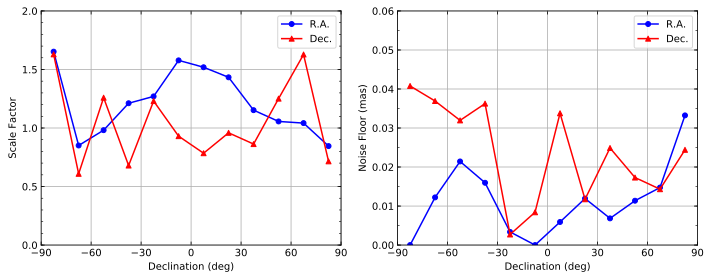

In [8]:
# Plot of declination-dependent noise and scale factor
fig, (ax0, ax1) = plt.subplots(figsize=(10, 4), ncols=2, sharex=True)

ax0.plot(dec_means, sf_RAs, "bo-", markersize=5, label="R.A.")
ax0.plot(dec_means, sf_Decs, "r^-", markersize=5, label="Dec.")
ax1.plot(dec_means, nf_RAs, "bo-", markersize=5, label="R.A.")
ax1.plot(dec_means, nf_Decs, "r^-", markersize=5, label="Dec.")

# ax0.set_xscale("log")
ax0.set_xlabel("Declination (deg)")
ax0.set_xlim([-90, 90])
ax0.set_xticks(np.arange(-90, 91, 30))
ax0.set_ylabel("Scale Factor")
ax0.set_ylim([0., 2])
ax0.set_yticks(np.arange(0., 2.1, 0.5))
ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax0.grid(True)
ax0.legend()

ax1.set_xlabel("Declination (deg)")
ax1.set_ylabel("Noise Floor (mas)")
ax1.set_ylim([0, 0.06])
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.grid(True)
ax1.legend()

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator = MultipleLocator(0.1)
ax0.yaxis.set_minor_locator(minorLocator)
minorLocator = MultipleLocator(0.005)
ax1.yaxis.set_minor_locator(minorLocator)

ax1.grid(True)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)